<a href="https://colab.research.google.com/github/Kiko-exe/Environmental-physics/blob/main/ENVPHYS200_ENSO_variability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENVPHYS 200: ENSO variability lab


The El Nino Southern Oscillation is a significant feature in the variability of global scale circulations. It is a phenomenon that links the atmosphere and ocean by the way ocean temperatures including surface winds. El Nino, the “warm” phase of the oscillation occurs with a period of approximately 5-8 years. The cooler periods in between are called La Nina, conditions.

Obtain datasets for monthly averages of ...
* mean sea level pressure (MSLP)
* 500 hPa Geopotential height (Z500)
* 500 hPa vertical velocity (W500)
* surface winds (USFC, VSFC)
* precipitation (PREC)
* sea surface temperature (SST).

Also obtain the data for the Multivariate ENSO Index (MEI).

We wish to examine how atmospheric circulation is related to the MEI.
We will focus only on data and conditions dueing January for the time period 1979 to 2023.

The guiding question might be phrased as...

_What type of conditions can I expect this comming summer?_

###Learning goals
* Patterns of atmospheric variability
* Relationships between ocean and atmospheric state
* Impact of El Nino on global, and New Zealand, climate


###Python goals
* Analysis of time series data.
* Use of linear regression function
* Statistical manipulating muti-dimensional gridded data with a time dimension.





In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

try:
    import netCDF4 as ncdf
except:
    print('NetCDF needs to be installed: this will take a few moments')
    !pip install netCDF4
    import netCDF4 as ncdf

try:
  import cartopy.crs as ccrs
except:
  print('cartopy needs to be installed: this will take a few moments')
  !pip install cartopy
  !pip uninstall shapely -y
  !pip install shapely --no-binary shapely
  import cartopy.crs as ccrs


# Download a data file from github, if it doesn't exist
!test ! -f ERA5_JAN_1978-2023.nc && wget 'http://kete.rangi.cloud.edu.au/u/dcn/ERA5_JAN_1978-2023.nc'
!test ! -f meiv2.data && wget 'https://raw.githubusercontent.com/davidnoone/GEOPHYS_NOTEBOOKS/main/data/meiv2.data'



NetCDF needs to be installed: this will take a few moments
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.2 MB/s eta 0:00:00
cartopy needs to be installed: this will take a few moments
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 25.0 MB/s eta 0:00:00
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=shapely-2.0.1-cp310-cp310-linux_x86_64.whl size=890041 sha256=4f7d6fc715d05411d64b2e1811e9e56e1c7497ac1ee809db65fe06244c399280
  Stored in directory: /root/.cache/pip/wheels/07/bd/06/4e979fa263bca266484ee65f5aab8e6b1c9b20f8caa6f2d7da

In [ ]:
# Some physical constants which we will need later
gravity = 9.81            # acceleration due to gravity [m/s]
rearth  = 6371000.        # radius of the earth [m]
omega   = 7.2921159e-5    # Rotation rate of earth (2 pi radians/day)
Rdry    = 287.            # gas constant for dry air [J/K/kg]

# Some definitions needed below for plotting
proj_grid = ccrs.PlateCarree(180)     # Map projection with 180 is the central longitude
proj_data = ccrs.PlateCarree(0)       # Data has "longitude", relative to 0 E.
figsize = [12,8]                      # size, in inches!


##Data
We will use data from the ECMWF 5th Reanalysis ("ERA5"). This data set is a comprehensive global 3d depiction of the atmosphere that spans from 1940 until today! It has developed in a way similar to opperational weather forecasts, by blending observations (from baloons, satellies, surface sites and other) with a state-of-the-art weather model. As a result a large number of variables are available for analysis.

Each of these variables exists on a latitude x longitude grid, which has a spacing of 1 degrees.

The original data comes in a data format called NetCDF, which is a very common data format for large atmospheric datasets. Python has a library that can read these data.

Here we are using monthly averages of January conditions each year.


In [ ]:
# Read in ERA5 atmospheric data

with ncdf.Dataset('ERA5_JAN_1978-2023.nc','r') as ncfile:    # open the file and read the data...
  lons  = ncfile.variables['longitude'][:]      # read the longitudes
  lats  = ncfile.variables['latitude'][:]       # read the latitudes
  mslp  = ncfile.variables['msl'][:,:,:]/100    # mean sea level pressure, Pa-> hPa
  prec  = ncfile.variables['tp'][:,:,:]*1000    # precipitation, m->mm per month
  t2m   = ncfile.variables['t2m'][:,:,:]        # air temperature at 2m, K
  sst   = ncfile.variables['sst'][:,:,:]        # sea surface temperature, K
  u10   = ncfile.variables['u10'][:,:,:]        # westerly wind at 10 m, m/s
  v10   = ncfile.variables['v10'][:,:,:]        # southerly wind at 10 m, m/s
  z500  = ncfile.variables['z'][:,:,:]/gravity  # 500 hPa heght, m2/s2 -> m
  w500  = ncfile.variables['w'][:,:,:]          # 500 hPa vertical velocity, Pa/sec

nlon = len(lons)
nlat = len(lats)


# open and read the MEI data file
df = pd.read_csv('meiv2.data', sep='\s+')

year = df['year'].to_numpy()
mei = df['JAN'].to_numpy()

print('year:',year)
print ('mei:',mei)

year: [1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023]
mei: [ 0.47  0.42 -0.28 -0.44  2.59 -0.38 -0.31 -0.42  0.96  0.64 -1.15  0.13
  0.13  1.63  0.91  0.06  0.75 -0.78 -0.83  2.24 -1.17 -1.22 -0.81 -0.07
  0.7   0.12  0.1  -0.67  0.61 -1.12 -0.99  1.03 -1.86 -1.12 -0.   -0.49
  0.17  1.9  -0.23 -0.76  0.04  0.22 -1.18 -1.06 -1.11]


Do a little check of the data, to make sure it is what we think it is!



In [ ]:

print("Shape of MEI :",np.shape(mei))
print("Shape of lats:",np.shape(lats))
print("Shape of lons:",np.shape(lons))
print("Shape of mslp:",np.shape(mslp))


#print('Latitudes:',lats)
#print('Longitudes:',lons)

Shape of MEI : (45,)
Shape of lats: (181,)
Shape of lons: (360,)
Shape of mslp: (45, 181, 360)


Inspired by the example from last weeks plotting assignment, here is a function that creates a "simple" contour plot.

Notice that the "extent", and projections need to be defined before it is called.



In [ ]:
# Inspired by Week 7 solution, here is a function that makes a contour plot
def my_contour_figure(data,num_levels=21,title='Unknown',cmap='jet',cline='black'):

    fig = plt.figure(figsize=figsize)                  # Create a figure
    ax = plt.axes(projection=proj_grid)
    ax.set_extent(extent,proj_data)
    ax.set_title(title)

    # Shaded contours for temperature: not colormap "jet" is one of many
    cf = plt.contourf(lons, lats, data, num_levels, cmap=cmap,transform=proj_data)
    plt.colorbar(cf)                                      # Add color bar

    # Overlay contour lines
    cl = plt.contour(lons, lats, data, num_levels, colors=cline,transform=proj_data)
    ax.clabel(cl, cl.levels, inline=True, fontsize=10)    # Add contour line liables

    # Add costlines and gridlines
    ax.coastlines(color='blue')
    ax.gridlines(crs=proj_grid, linewidth=1, color='cyan',
        draw_labels=True, alpha=0.5, linestyle='--')

    return



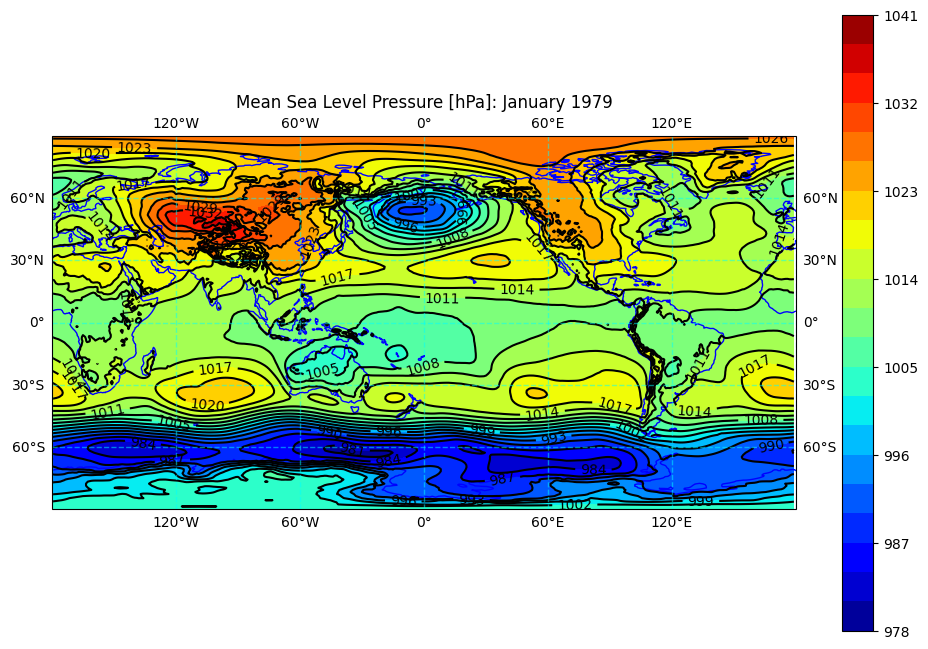

In [ ]:
# Example using the function above: plotting mean sea level

# Set region of the world toplot: extnt = [lon_min, lon_max, lat_min, lat_max]
#extent = [140, 200, -65, -10]       # New Zealand region
#extent = [120, 200, -50, 0]         # South Pacific near New Zealand
extent = [0, 360, -90, 90]           # Global

# Use the function above to make a plot
itime = 0       # Select which time slice to plot!    [ CHANGE THIS FOR DIFFERENT YEARS]
my_contour_figure(mslp[itime,:,:],title='Mean Sea Level Pressure [hPa]: January '+str(year[itime]))


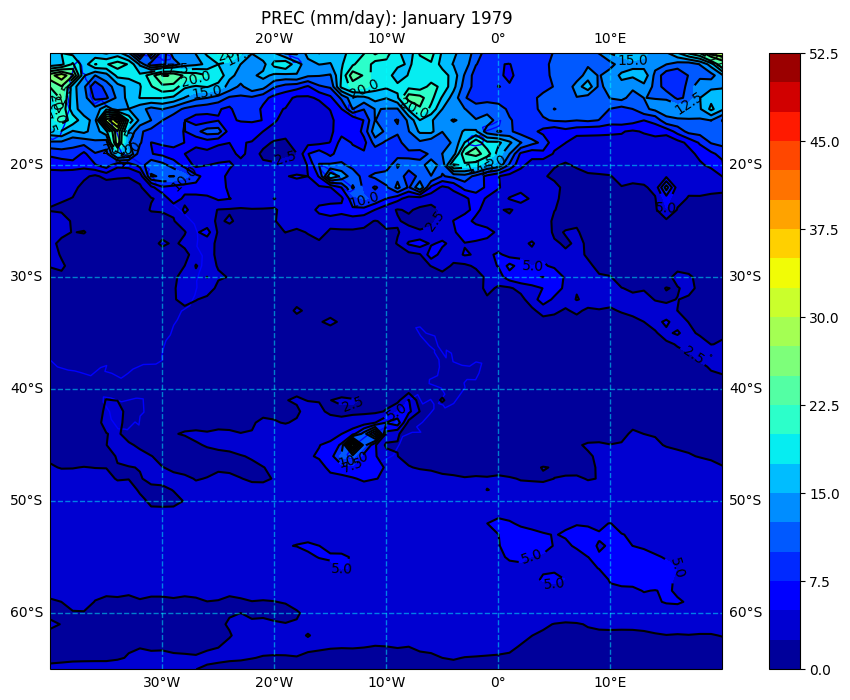

In [ ]:
# Example using the function above: plotting mean sea level

# Set region of the world toplot: extnt = [lon_min, lon_max, lat_min, lat_max]
extent = [140, 200, -65, -10]       # New Zealand region
#extent = [120, 200, -50, 0]         # South Pacific near New Zealand
#extent = [0, 360, -90, 90]           # Global

# Use the function above to make a plot
itime = 0       # Select which time slice to plot!    [ CHANGE THIS FOR DIFFERENT YEARS]
my_contour_figure(prec[itime,:,:],title='PREC (mm/day): January '+str(year[itime]))


---
### Task a)	Construct a time series plot of the MEI.


Text(0, 0.5, 'January MEI')

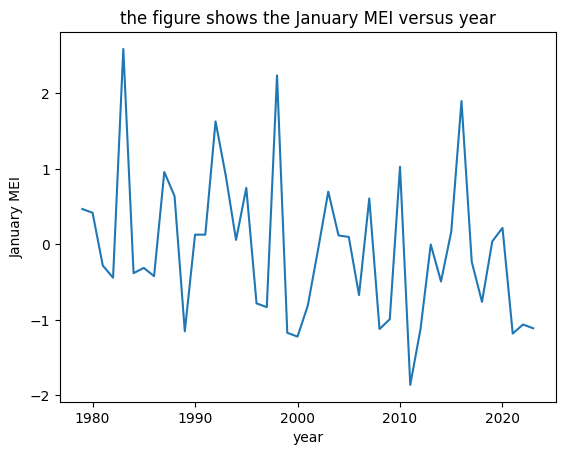

In [ ]:
# Your code to make a time series plot: January MEI versus year.
# You will need to use the matplot.lib functions:

fig = plt.figure()
plt.plot(year,mei)

# Make sure to include axis labels and a title!
plt.title('the figure shows the January MEI versus year')
plt.xlabel("year")
plt.ylabel("January MEI")


---
### Task b)	What are the units of the MEI?

---
### Task c)	From your plot, identify periods in the last few decades for which there have been strong El Nino events.

List of years:

---
### Task d)	Make a contour plot of SST. Also make a contour plot of precipitation and surface easterly winds.

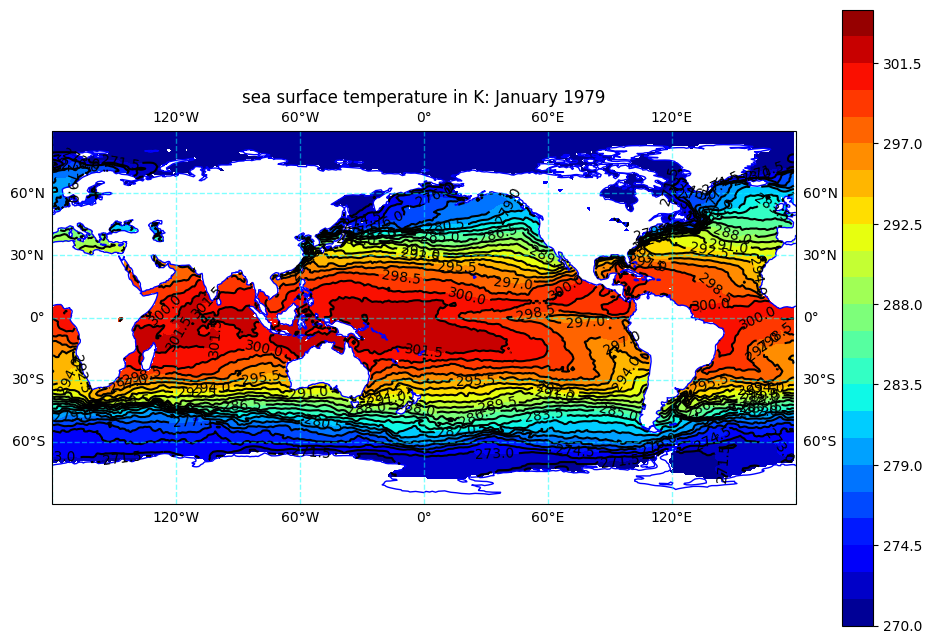

In [ ]:
# Set region of the world toplot: extnt = [lon_min, lon_max, lat_min, lat_max]
#extent = [140, 200, -65, -10]       # New Zealand region
#extent = [120, 200, -50, 0]         # South Pacific near New Zealand
extent = [0, 360, -90, 90]           # Global

# Use the function above to make a plot
itime = 0       # Select which time slice to plot!    [ CHANGE THIS FOR DIFFERENT YEARS]
my_contour_figure(sst[itime,:,:],title='sea surface temperature in K: January '+str(year[itime]))



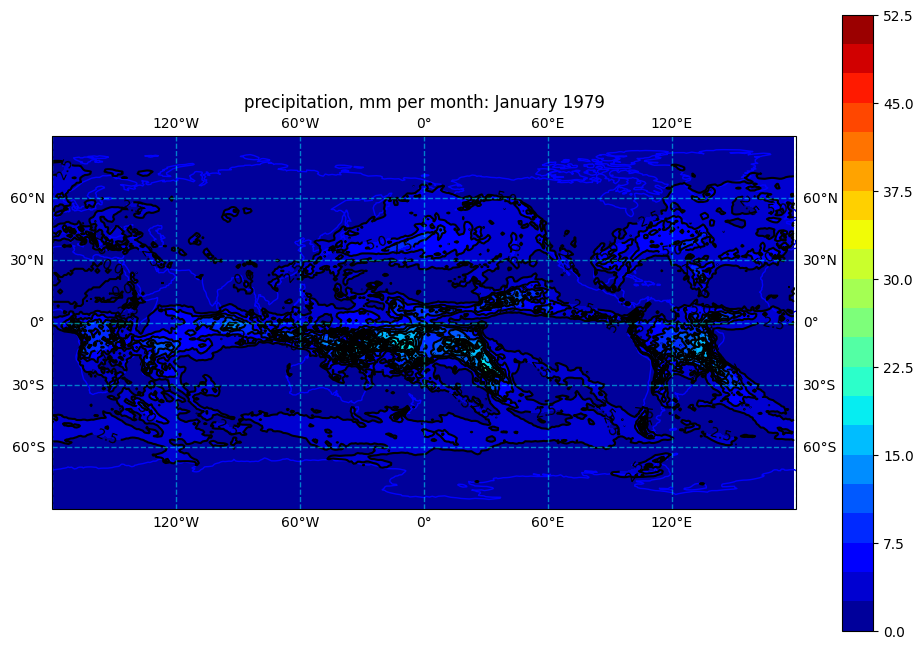

In [ ]:
# Example using the function above: plotting mean sea level

# Set region of the world toplot: extnt = [lon_min, lon_max, lat_min, lat_max]
#extent = [140, 200, -65, -10]       # New Zealand region
#extent = [120, 200, -50, 0]         # South Pacific near New Zealand
extent = [0, 360, -90, 90]           # Global

# Use the function above to make a plot
itime = 0       # Select which time slice to plot!    [ CHANGE THIS FOR DIFFERENT YEARS]
my_contour_figure(prec[itime,:,:],title='precipitation, mm per month: January '+str(year[itime]))


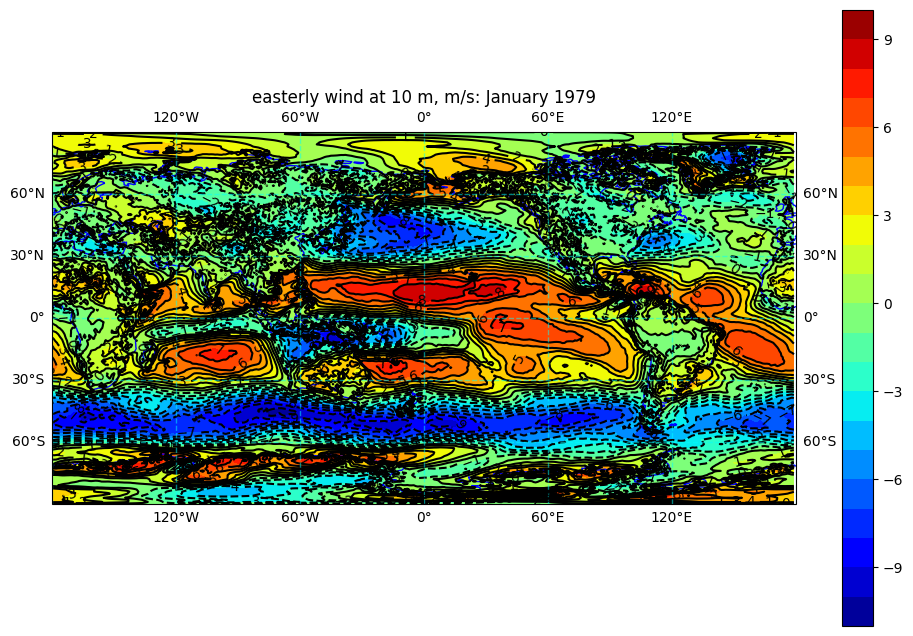

In [ ]:
# Example using the function above: plotting mean sea level

# Set region of the world toplot: extnt = [lon_min, lon_max, lat_min, lat_max]
#extent = [140, 200, -65, -10]       # New Zealand region
#extent = [120, 200, -50, 0]         # South Pacific near New Zealand
extent = [0, 360, -90, 90]           # Global

# Use the function above to make a plot
itime = 0       # Select which time slice to plot!    [ CHANGE THIS FOR DIFFERENT YEARS]
my_contour_figure(-u10[itime,:,:],title='easterly wind at 10 m, m/s: January '+str(year[itime]))


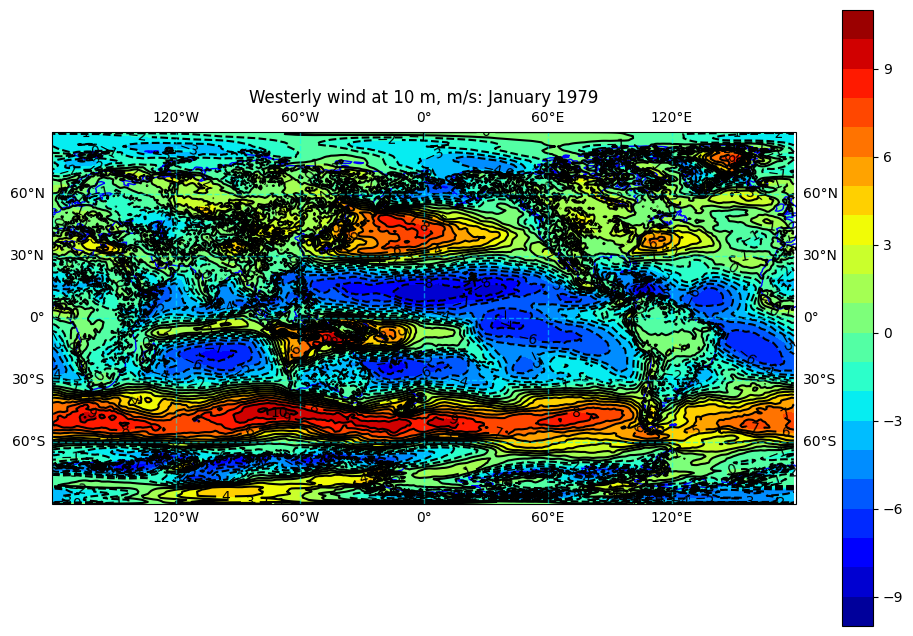

In [ ]:
# Example using the function above: plotting mean sea level

# Set region of the world toplot: extnt = [lon_min, lon_max, lat_min, lat_max]
#extent = [140, 200, -65, -10]       # New Zealand region
#extent = [120, 200, -50, 0]         # South Pacific near New Zealand
extent = [0, 360, -90, 90]           # Global

# Use the function above to make a plot
itime = 0       # Select which time slice to plot!    [ CHANGE THIS FOR DIFFERENT YEARS]
my_contour_figure(u10[itime,:,:],title='Westerly wind at 10 m, m/s: January '+str(year[itime]))


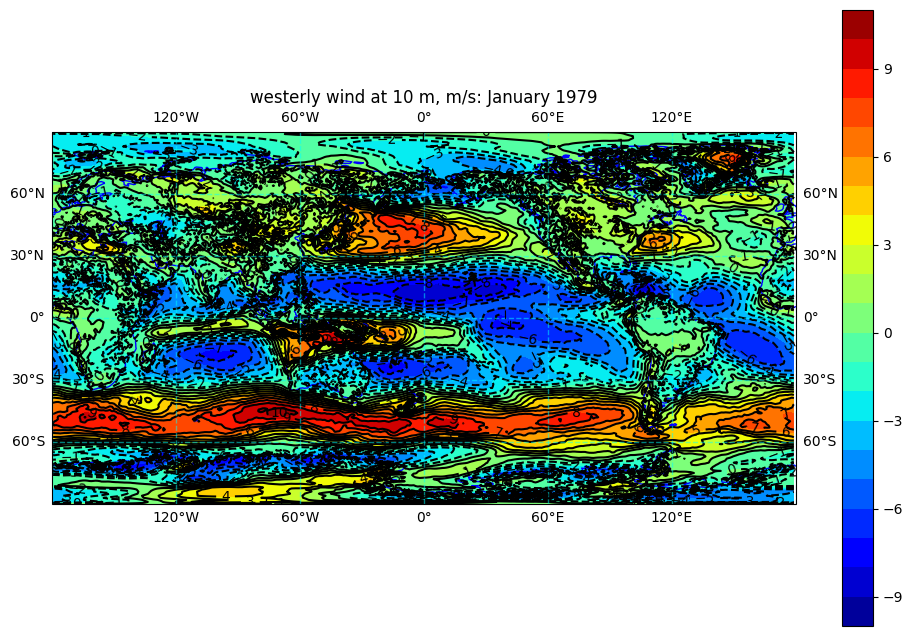

In [ ]:
# Example using the function above: plotting mean sea level

# Set region of the world toplot: extnt = [lon_min, lon_max, lat_min, lat_max]
#extent = [140, 200, -65, -10]       # New Zealand region
#extent = [120, 200, -50, 0]         # South Pacific near New Zealand
extent = [0, 360, -90, 90]           # Global

# Use the function above to make a plot
itime = 0       # Select which time slice to plot!    [ CHANGE THIS FOR DIFFERENT YEARS]
my_contour_figure(u10[itime,:,:],title='westerly wind at 10 m, m/s: January '+str(year[itime]))


---
### Task e)	From your SST plot, identify and describe regions where you expect to observe upwelling.

---
### Task f)	From your surface wind and MSLP plot, identify (and describe) evidence of the Walker circulation.


---
### Task g)	Make a contour plots showing the regression of the MEI with each of the fields.

(To analyze how El Nino influences the climatology we wish to examine the linear relationship between the MEI and other quantities)


We wish to consider the "slope" as the linear relationship between the MEI and some quantity, for instance, MSLP.
MSLP is a 3d data field with dimensions: MSLP[time,latitude,longitude].
We can consider this as a time series at each point. Thus, what is needed is compute the slope $\Delta (MSLP) / \Delta (MEI)$ at each point i, j.


In [ ]:
def regression_map(x_series,y_grid,):
  """ Computes the "slope" of data versus series for each point in the data map"""
  slope_map = np.zeros((nlat,nlon))

  # loop over each point on the latitude/longitude grid
  for j in range(nlat):
    for i in range(nlon):
      y_series = np.squeeze(y_grid[:,j,i])    # get the time series at a single point

      # perform linear regression at each point:
      slope, intercept, r_value, p_value, std_err = linregress(x_series, y_series)
      slope_map[j,i] = slope      # save the slope!
                                  # Could also save the "r" or "p" value for

  return slope_map



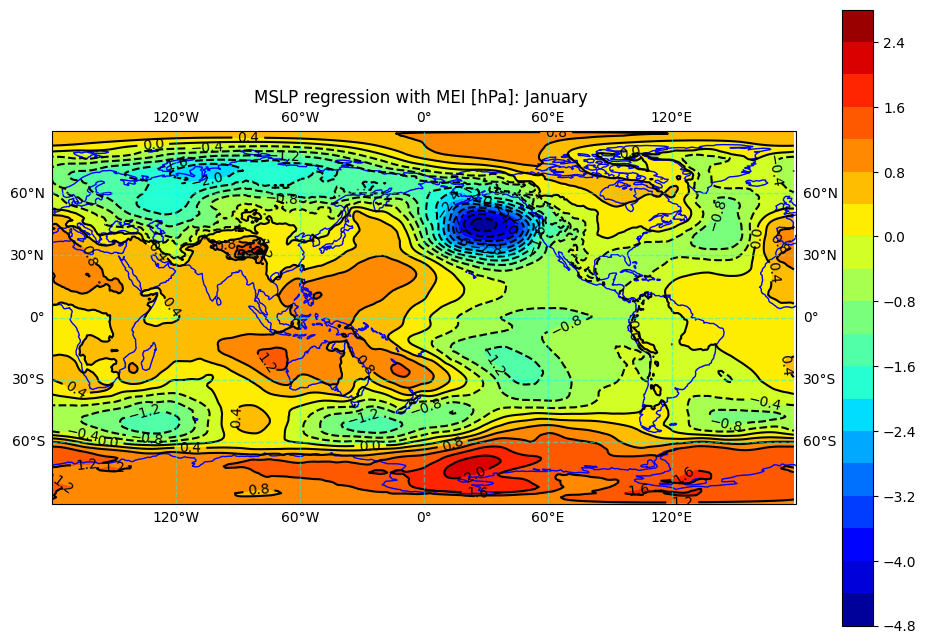

In [ ]:
# Your plots here: you may wish to use the plottig funtion defined above.

reg_mslp = regression_map(mei,mslp)

# PLOT!
my_contour_figure(reg_mslp,title='MSLP regression with MEI [hPa]: January ')



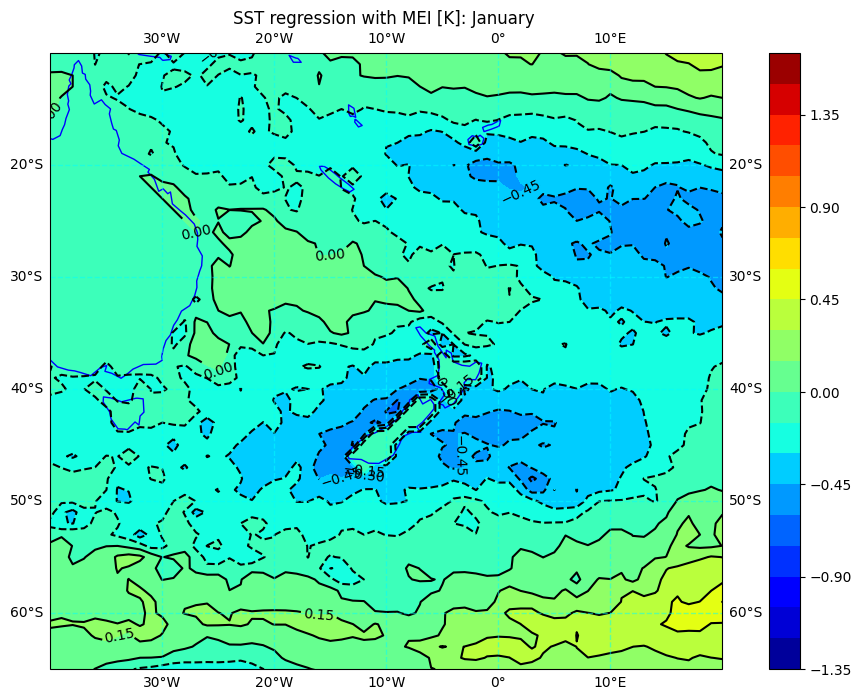

In [ ]:
# Your plots here: you may wish to use the plottig funtion defined above.
extent = [140, 200, -65, -10]
reg_sst = regression_map(mei,sst)

# PLOT!
my_contour_figure(reg_sst,title='SST regression with MEI [K]: January ')



In [ ]:
# Your plots here: you may wish to use the plottig funtion defined above.
extent = [140, 200, -65, -10]
reg_prec= regression_map(mei,prec)

# PLOT!
my_contour_figure(reg_prec,title='PREC regression with MEI [mm per month]: January ')



KeyboardInterrupt: ignored

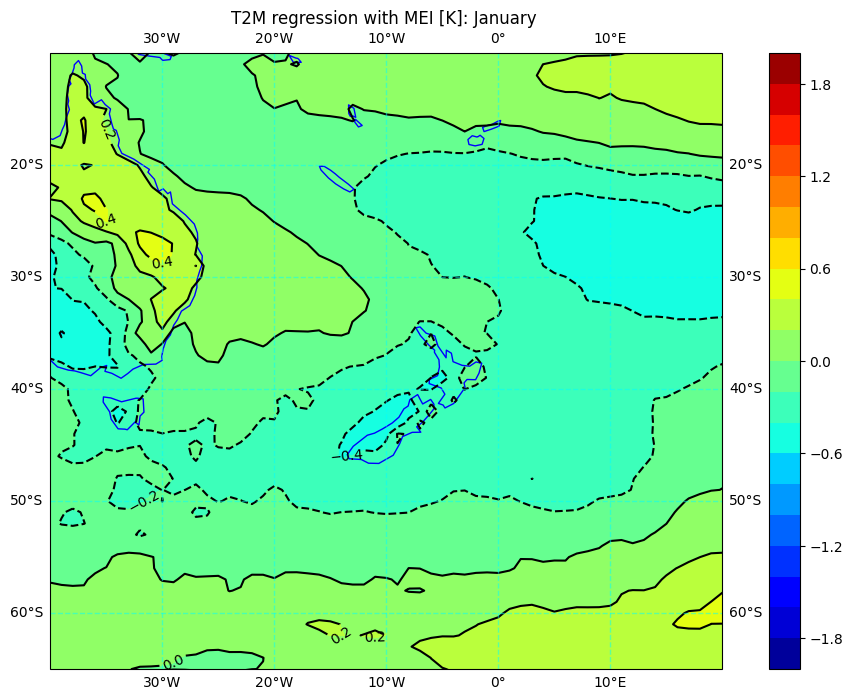

In [ ]:
# Your plots here: you may wish to use the plottig funtion defined above.
extent = [140, 200, -65, -10]
reg_t2m= regression_map(mei,t2m)

# PLOT!
my_contour_figure(reg_t2m,title='T2M regression with MEI [K]: January ')



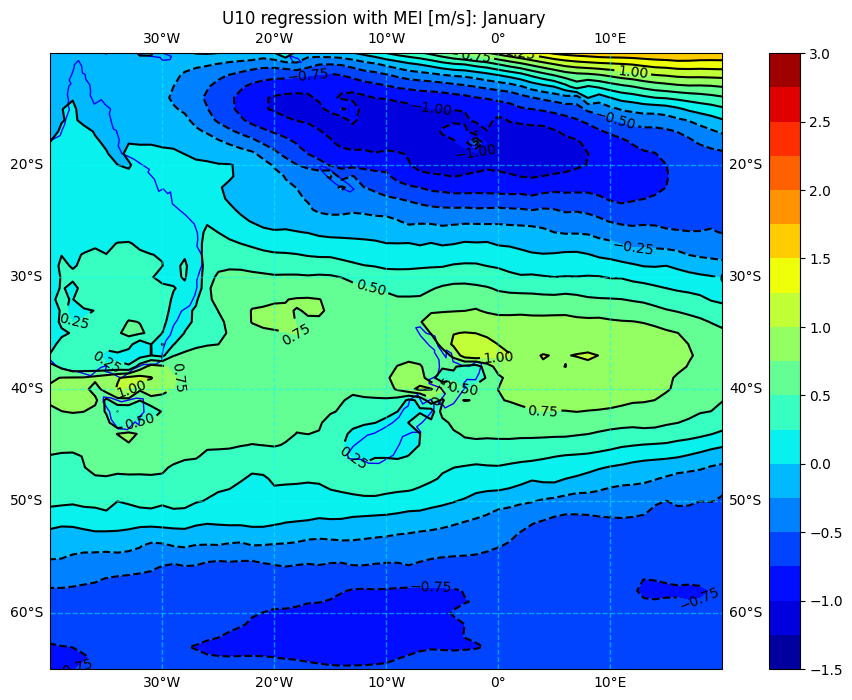

In [ ]:
# Your plots here: you may wish to use the plottig funtion defined above.
extent = [140, 200, -65, -10]
reg_u10= regression_map(mei,u10)

# PLOT!
my_contour_figure(reg_u10,title='U10 regression with MEI [m/s]: January ')



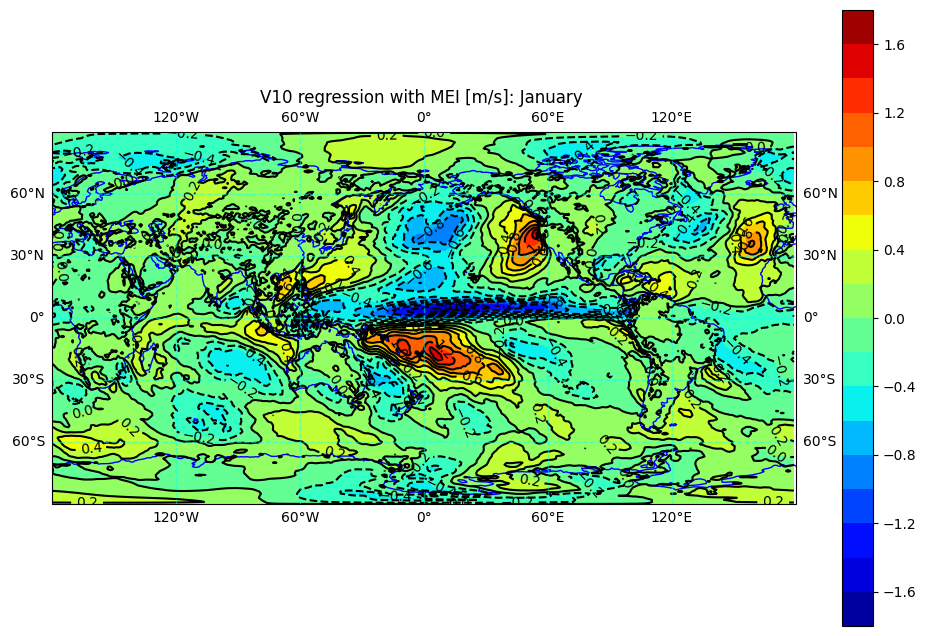

In [ ]:
# Your plots here: you may wish to use the plottig funtion defined above.

reg_v10= regression_map(mei,v10)

# PLOT!
my_contour_figure(reg_v10,title='V10 regression with MEI [m/s]: January ')



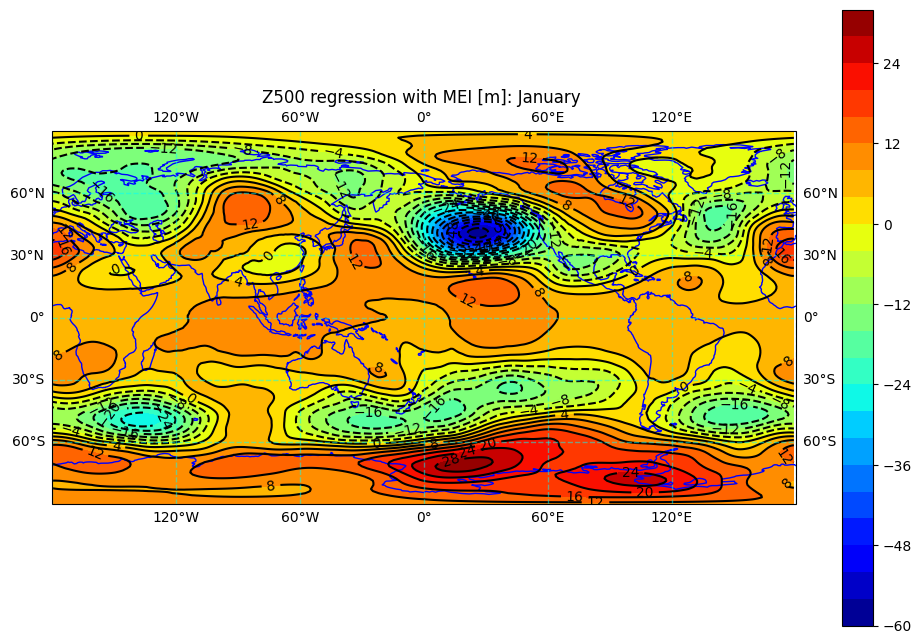

In [ ]:
# Your plots here: you may wish to use the plottig funtion defined above.

reg_z500= regression_map(mei,z500)

# PLOT!
my_contour_figure(reg_z500,title='Z500 regression with MEI [m]: January ')



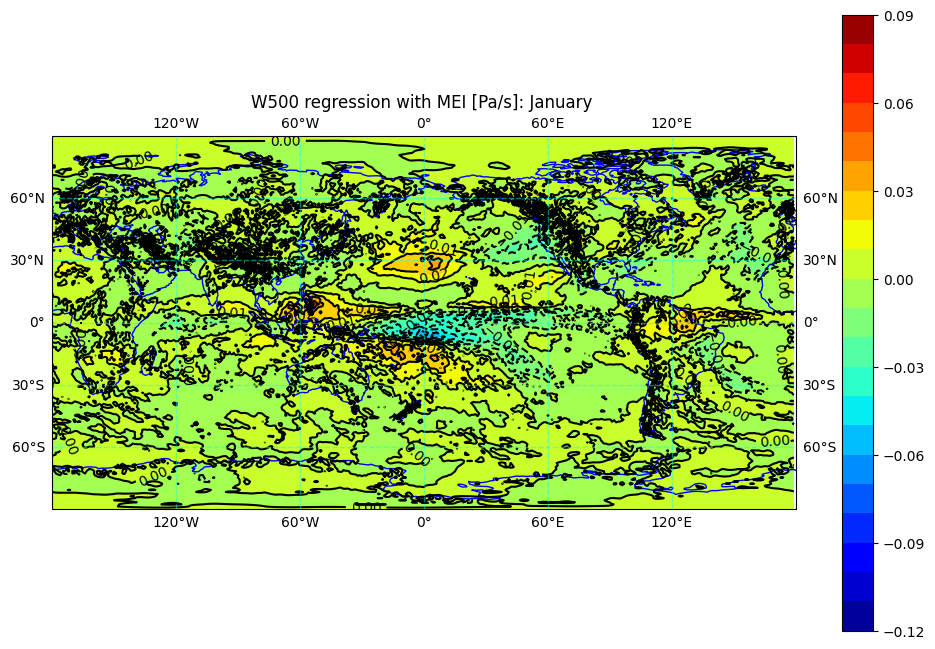

In [ ]:
# Your plots here: you may wish to use the plottig funtion defined above.

reg_w500= regression_map(mei,w500)

# PLOT!
my_contour_figure(reg_w500,title='W500 regression with MEI [Pa/s]: January ')



---
### Task i)	Making reference to your figures, describe how you see evidence of the Bjerknes feedback in the regression maps of SST, surface westerly winds, vertical velocity, and precipitation.

---
### Task j)	Make a prediction for the likely weather conditions near Auckland for the summer, January 2024.

There is a prediction that the coming summer (2023/2024) an El Nino event will emerge. Making reference to your diagrams and analysis, What is your expectation for rainfall, temperature and wind?

---
# Outcome

Having reached the end, you have now learned to be able to perform statistical analysis of time series and complex 3d (!) gridded datasets. Datasets like these, and these types of methods are using in wide areas of climate research, including analysis of future climate change, seasonal weather prediction and other types of analysis of climate impacts.

Here, you've been able to use oberservations, matched with a thery for the development of coupled ocean-atmosphere phenomena (i.e., ENSO), to make a statistical prediction for the upcoming summer season.


In [ ]:
#